# Calcium Imaging Quality Metrics

Visualize the calcium imaging quality metrics for the raw and processed scans that are stored in the DataJoint pipeline (i.e. `element-calcium-imaging`).

If you are new to using this DataJoint pipeline for analyzing calcium imaging data, please see the [tutorial](./tutorial.ipynb) notebook for an in-depth explanation to set up and run the workflow.

This quality metrics notebook can run in a [GitHub Codespace](https://github.com/datajoint/element-calcium-imaging#interactive-tutorial), and requires the example data to be populated into the database using the [tutorial](./tutorial.ipynb) notebook.

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tests.tutorial_pipeline import scan, imaging

[2024-01-11 02:17:51,744][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2024-01-11 02:17:51,746][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-01-11 02:17:51,755][INFO]: Connected root@fakeservices.datajoint.io:3306


## Populate quality metrics tables

In [2]:
scan.ScanQualityMetrics.populate(display_progress=True)
imaging.ProcessingQualityMetrics.populate(display_progress=True)

## Scan quality metrics

Intensity values (minimum, mean, max, contrast) can be used to evaluate the consistency of imaging for each frame, and changing values could indicate changes in imaging conditions or technical issues with the equipment or software (e.g. photobleaching, saturation, etc.). In which case, it may be necessary to adjust the imaging protocol, or troubleshoot the equipment or software.

In [3]:
scan.ScanQualityMetrics.Frames()

subject,session_datetime,scan_id,field_idx,channel 0-based indexing,min_intensity Minimum value of each frame.,mean_intensity Mean value of each frame.,max_intensity Maximum value of each frame.,contrast Contrast of each frame (i.e. difference between the 99 and 1 percentiles)
subject1,2021-04-30 12:22:15,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [4]:
key = dict(
    subject="subject1",
    session_datetime=datetime.datetime(2021, 4, 30, 12, 22, 15),
    scan_id=0,
    field_idx=0,
    channel=0,
)

query = scan.ScanQualityMetrics.Frames & key
query

subject,session_datetime,scan_id,field_idx,channel 0-based indexing,min_intensity Minimum value of each frame.,mean_intensity Mean value of each frame.,max_intensity Maximum value of each frame.,contrast Contrast of each frame (i.e. difference between the 99 and 1 percentiles)
subject1,2021-04-30 12:22:15,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [5]:
scan_metrics = query.fetch1()

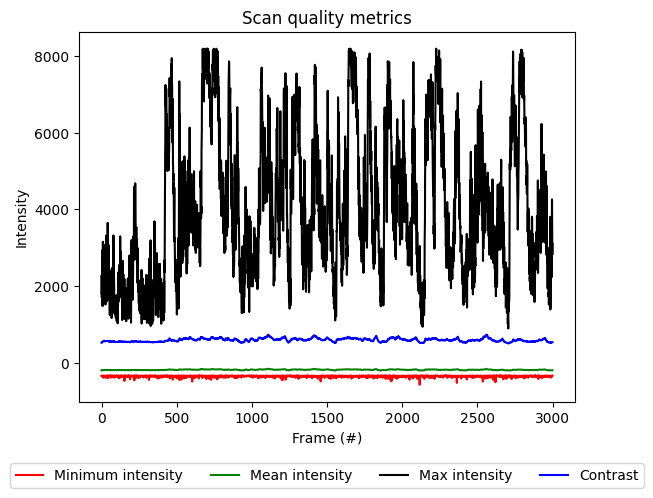

In [6]:
plt.plot(
    range(len(scan_metrics["min_intensity"])),
    scan_metrics["min_intensity"],
    label="Minimum intensity",
    color="red",
)

plt.plot(
    range(len(scan_metrics["mean_intensity"])),
    scan_metrics["mean_intensity"],
    label="Mean intensity",
    color="green",
)

plt.plot(
    range(len(scan_metrics["max_intensity"])),
    scan_metrics["max_intensity"],
    label="Max intensity",
    color="black",
)

plt.plot(
    range(len(scan_metrics["contrast"])),
    scan_metrics["contrast"],
    label="Contrast",
    color="blue",
)

plt.title("Scan quality metrics")
plt.xlabel("Frame (#)")
plt.ylabel("Intensity")
plt.legend(loc="center", bbox_to_anchor=(0.5, -0.2), ncol=4)
plt.show()

## Motion corrected summary images

In [7]:
key = dict(
    subject="subject1",
    session_datetime=datetime.datetime(2021, 4, 30, 12, 22, 15),
    scan_id=0,
    paramset_idx=0,
    curation_id=0,
    field_idx=0,
)
query = imaging.MotionCorrection.Summary & key
query

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,field_idx,ref_image image used as alignment template,average_image mean of registered frames,correlation_image correlation map (computed during cell detection),max_proj_image max of registered frames
subject1,2021-04-30 12:22:15,0,0,0,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [8]:
summary_images = query.fetch1()

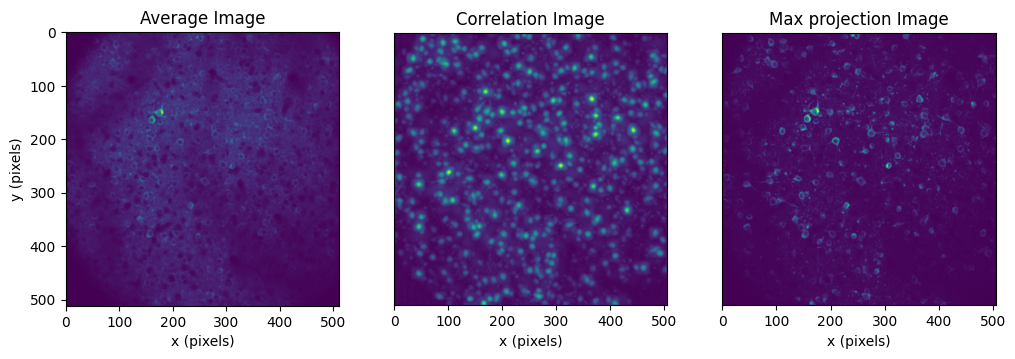

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 9))

axes[0].imshow(summary_images["average_image"])
axes[0].set_title("Average Image")
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("y (pixels)")

axes[1].imshow(summary_images["correlation_image"])
axes[1].set_title("Correlation Image")
axes[1].set_xlabel("x (pixels)")
axes[1].set_yticks([])
axes[1].set_yticklabels([])

axes[2].imshow(summary_images["max_proj_image"])
axes[2].set_title("Max projection Image")
axes[2].set_xlabel("x (pixels)")
axes[2].set_yticks([])
axes[2].set_yticklabels([])

plt.show()

## Segmentation masks

index 504 is out of bounds for axis 0 with size 504
index 504 is out of bounds for axis 0 with size 504
index 504 is out of bounds for axis 0 with size 504
index 504 is out of bounds for axis 0 with size 504
index 504 is out of bounds for axis 0 with size 504
index 506 is out of bounds for axis 1 with size 506
index 506 is out of bounds for axis 1 with size 506
index 504 is out of bounds for axis 0 with size 504


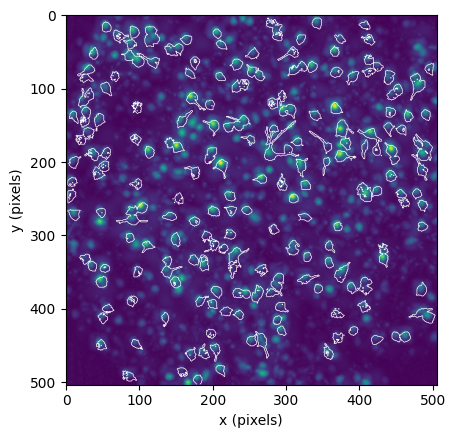

In [10]:
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & key
    & "mask_center_z=0"
    & "mask_npix > 100"
    & "confidence > 0.90"
).fetch("mask_xpix", "mask_ypix")

mask_image = np.zeros(np.shape(summary_images["correlation_image"]), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    try:
        mask_image[ypix, xpix] = True
    except Exception as e:
        print(e)

plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.imshow(summary_images["correlation_image"])
plt.contour(mask_image, colors="white", linewidths=0.5)
plt.show()

## Mask quality metrics

| Metric | Description | Source |
| -- | -- | -- |
| Mask area | Area can be used to evaluate the accuracy and consistency of the segmentation process. The mask area can be compared to the expected area of a single cell to determine if segmentation lead to false positives or false negatives. | [Stringer & Pachitariu, Current Opinion in Neurobiology 2019](https://doi.org/10.1016/j.conb.2018.11.005) |
| Mask roundness | Roundness is to evaluate how closely a segmented mask's shape resembles a perfect circle. A perfectly round mask will have a value of 1, while a more elongated or irregular mask will have a lower roundness value. Roundness can help identify cells that have been improperly segmented. For example, cells that are elongated or irregular in shape may have been segmented incorrectly due to noise, overlapping cells, or other factors. By comparing the roundness of segmented masks to a threshold value, cells that are improperly segmented can be identified and corrected. | [Tegtmeier et al., Frontiers in Neuroscience 2018](https://doi.org/10.3389/fnins.2018.00958) |

In [11]:
key = dict(
    subject="subject1",
    session_datetime=datetime.datetime(2021, 4, 30, 12, 22, 15),
    scan_id=0,
    paramset_idx=0,
    curation_id=0,
)

query = imaging.ProcessingQualityMetrics.Mask & key
query

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,mask,mask_area Mask area in square micrometer.,roundness Roundness between 0 and 1. Values closer to 1 are rounder.
subject1,2021-04-30 12:22:15,0,0,0,0,nan,0.753574
subject1,2021-04-30 12:22:15,0,0,0,1,nan,0.749964
subject1,2021-04-30 12:22:15,0,0,0,2,nan,0.843484
subject1,2021-04-30 12:22:15,0,0,0,3,nan,0.646408
subject1,2021-04-30 12:22:15,0,0,0,4,nan,0.721577
subject1,2021-04-30 12:22:15,0,0,0,5,nan,0.712069
subject1,2021-04-30 12:22:15,0,0,0,6,nan,0.734321
subject1,2021-04-30 12:22:15,0,0,0,7,nan,0.684134
subject1,2021-04-30 12:22:15,0,0,0,8,nan,0.600041
subject1,2021-04-30 12:22:15,0,0,0,9,nan,0.903313


In [12]:
roundness = query.fetch("roundness")

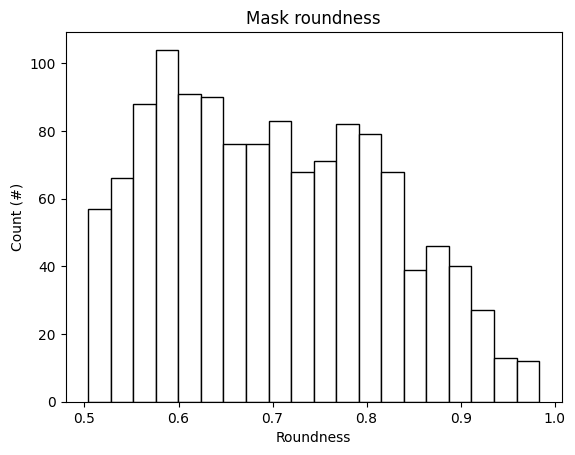

In [13]:
plt.hist(roundness, bins=20, color="white", edgecolor="black")

plt.title("Mask roundness")
plt.xlabel("Roundness")
plt.ylabel("Count (#)")
plt.show()

## Trace quality metrics

Temporal skewness and variance of the fluorescence activity can indicate the stability of the signal over time. Changes in this metric between imaging sessions could indicate technical issues in the experimental conditions or data processing. Additionally, changes in the animal's behavior or physiological state could also affect this metric, so it is important to interpret any changes within the context of the experimental conditions and the animal's behavior and physiology. ([Stringer & Pachitariu, Current Opinion in Neurobiology 2019](https://doi.org/10.1016/j.conb.2018.11.005))

For illustrative purposes, below we will fetch and plot these metrics for a single session.

In [14]:
key = dict(
    subject="subject1",
    session_datetime=datetime.datetime(2021, 4, 30, 12, 22, 15),
    scan_id=0,
    paramset_idx=0,
    curation_id=0,
    fluo_channel=0,
)

query = imaging.ProcessingQualityMetrics.Trace & key
query

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,mask,fluo_channel 0-based indexing,skewness Skewness of the fluorescence trace.,variance Variance of the fluorescence trace.
subject1,2021-04-30 12:22:15,0,0,0,0,0,2.28541,865.221
subject1,2021-04-30 12:22:15,0,0,0,1,0,2.18231,342.718
subject1,2021-04-30 12:22:15,0,0,0,2,0,2.49255,784.625
subject1,2021-04-30 12:22:15,0,0,0,3,0,3.98893,153.951
subject1,2021-04-30 12:22:15,0,0,0,4,0,2.83063,315.717
subject1,2021-04-30 12:22:15,0,0,0,5,0,2.74945,194.228
subject1,2021-04-30 12:22:15,0,0,0,6,0,6.43236,183.582
subject1,2021-04-30 12:22:15,0,0,0,7,0,4.58705,184.103
subject1,2021-04-30 12:22:15,0,0,0,8,0,3.45196,204.443
subject1,2021-04-30 12:22:15,0,0,0,9,0,3.10743,237.697


In [15]:
skewness, variance = query.fetch("skewness", "variance")

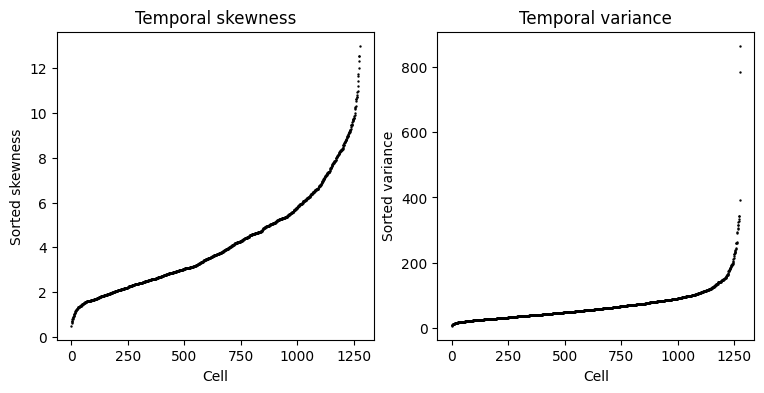

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].scatter(range(len(skewness)), np.sort(skewness), color="black", s=0.5)
axes[0].set_title("Temporal skewness")
axes[0].set_xlabel("Cell")
axes[0].set_ylabel("Sorted skewness")

axes[1].scatter(range(len(variance)), np.sort(variance), color="black", s=0.5)
axes[1].set_title("Temporal variance")
axes[1].set_xlabel("Cell")
axes[1].set_ylabel("Sorted variance")

plt.show()